# Post Translational Modification of a Protein - PROTOTYPE

This notebook demonstrates Open Force Field's prototype workflow for simulating a post-translationally modified protein.

We'd love to know your thoughts! Please submit feedback as an [issue] on the [`ptm_prototype` repository]

[`ptm_prototype` repository]: https://github.com/openforcefield/ptm_prototype
[issue]: https://github.com/openforcefield/ptm_prototype/issues/new

### Outline

1. Prepare a Pablo residue definition for the PTM residue
2. Load a PDB file containing the PTM residue
3. Solvate with the OpenFF PackMOL wrapper
4. Parametrize the solvated system using the new OpenFF 3.0.0-alpha0 force field
5. Run a short simulation in OpenMM


The big innovations in this prototype are:

- The OpenFF 3.0.0-alpha0 force field, which supports proteins and druglike small molecules[*](#rosemary-footnote)
- The AshGC charge model, a graph neural network charge model used by the latest OpenFF force fields to quickly produce high quality, conformer independent charges even for large molecules like post-translationally modified proteins
- The Pablo PDB loader, which uses a much more flexible chemical identification system than the existing `from_pdb` methods.

<span id="rosemary-footnote" style="font-size:0.8em">*For now, Rosemary is in Alpha. It hasn’t yet been updated to preserve performance on small molecules, so you might get some strange results here.</span>

## Prepare a residue definition for the PTM residue

We'd love to be able to just pull down any old PDB file and parametrize it, but the cost of being able to directly parametrize nearly any drug-like molecule is that we do need to know exactly what that molecule is, including its bond orders and formal charges. Unfortunately, PDBs just don't include that information. The Pablo loader tries to make it as easy as possible to load PDB files with chemistries both unusual and mundane!

The new Pablo PDB loader uses a unified [`ResidueDefinition`] dataclass to specify how to load a particular residue. Pablo can use residue definitions that don't specify atom and residue names as long as elements and connectivity are present in the PDB file, and it can use residue definitions that can infer connectivity from atom and residue names by specifying those names. Pablo's default residue library supports many PTM residues, as it includes support for loading residue definitions from the [CCD]. For this example however, we'll define our own definition for a novel post-translation modification. We'll use a so-called "anonymous" definition, because it saves us having to deal with the names, and because most software can produce PDB files with CONECT records for nonstandard residues.

Our post-translationally modified protein contains a cysteine residue that has been labeled with a fluorescein maleimide dye. Labelling occurs in the lab via a synthetic thiol-maleimide "click" reaction that is specific to cysteine residues in proteins:

![Reaction schema of a thiol group reacting with an N-substituted maleimide at the carbon-carbon double bond to form the corresponding pyrrolidine](reaction.png)

We'll generate this residue definition by reacting the standard cysteine definition with an SDF of the fluorescein maleimide dye, but there are lots of ways to produce residue definitions. See the [Pablo docs](https://openff-pablo.readthedocs.io/en/stable/) for more information! 

[`ResidueDefinition`]: https://openff-pablo.readthedocs.io/en/stable/api/generated/openff.pablo.ResidueDefinition.html
[CCD]: https://www.wwpdb.org/data/ccd

The default residue database used by Pablo is `STD_CCD_CACHE`. This object presents the `Mapping` interface, and so residues can be read just like from a dictionary. Behind the scenes, the cache downloads and caches CIF files from the [CCD], processes them into residue definitions, and patches them to improve compatibility with diverse PDB files. For example, we can take a look at the CCD's cysteine definition:

[CCD]: https://www.wwpdb.org/data/ccd

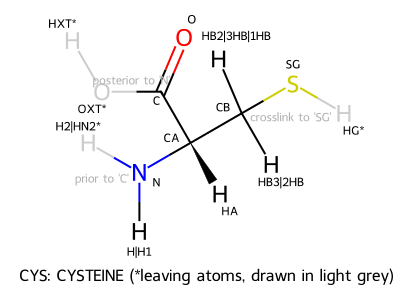

In [1]:
from openff.pablo import STD_CCD_CACHE

cysteine_resdef = STD_CCD_CACHE["CYS"][0]
cysteine_resdef.visualize()

In this depiction, each atom is labeled by the possible names it may have in a PDB file, and then finally a asterisk if it is absent when a bond is formed between this residue and another.

Next, we'll load the maleimide dye from an SDF file:

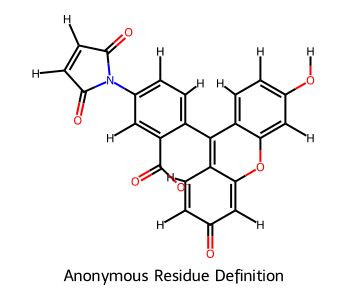

In [2]:
from openff.pablo import ResidueDefinition

maleimide_resdef = ResidueDefinition.anon_from_sdf("maleimide.sdf")
maleimide_resdef.visualize()

Finally, we'll `react()` the two definitions together to form our final residue, preserving the leaving fragments from the original Cysteine residue so that this definition defines a substructure:

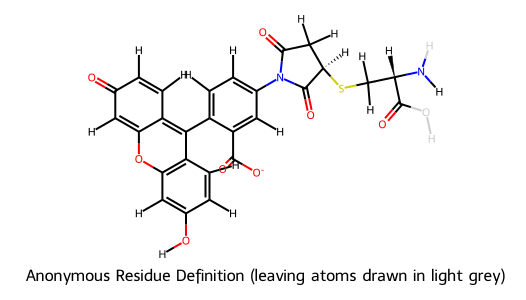

In [3]:
# react() takes a list of reactant residue definitions and a reaction SMARTS and produces a list of the possible outcomes of the reaction
# Each possible outcome is represented by a tuple of product ResidueDefinition objects
dye_resdef = ResidueDefinition.react(
    reactants=[cysteine_resdef, maleimide_resdef],
    reactant_smarts = [
        "[C:10]-[S:1]-[H:2]",
        "[N:3]1-[C:4](=[O:5])-[C:6](-[H:11])=[C:7](-[H:12])-[C:8](=[O:9])-1",
    ],
    product_smarts = [
        "[N:3]1-[C:4](=[O:5])-[C:6](-[H:2])(-[H:11])-[C@:7](-[S:1]-[C:10])(-[H:12])-[C:8](=[O:9])-1",
    ],
)[0][0] # Returns a list of tuples, we want the first (and only) element of any (identical) tuple
dye_resdef.visualize()

<div style="border-left: 10px solid #eeee00; box-shadow: 5px 5px 12.5px #999999; border-radius: 5px; margin: 15px; padding: 15px;">
💡 This is just one example of how to construct a residue definition - if it doesn't suit your needs, check out the <code>ResidueDefinition</code> <a href=https://openff-pablo.readthedocs.io/en/stable/api/generated/openff.pablo.ResidueDefinition.html#openff-pablo-residuedefinition-constructors>constructor methods</a> and the <a href=https://openff-pablo.readthedocs.io/en/stable/book/05-resdef.html>Pablo book</a> for alternatives!
</div>


## Load a PDB file containing the PTM residue

Now, we just load the PDB file using the default CCD cache, asking Pablo to fill in any gaps in the CCD parametrization with our new dye residue definition. The "leaving atoms" in the residue definition can be missing, as long as the bond from a non-leaving atom to a leaving atom is present, so this works on substructures like the post-translationally modified amino acid residue we have here.

In [ ]:
from openff.pablo import topology_from_pdb

topology = topology_from_pdb(
    "3ip9_dye.pdb",
    additional_definitions=[dye_resdef],
)

We now have a standard OpenFF `Topology` object, which we can visualize with the familiar methods:

In [ ]:
w = topology.visualize()
w.clear_representations()
w.add_cartoon()
w.add_line(opacity=0.66, crossSize=1.0, linewidth=3)
w.add_licorice("DYE", radius=0.3)
w.add_unitcell()
w.center("DYE")
w

If you look closely at where the line representation of the protein meets the licorice representation of the dye, you can see that the dye residue is fully integrated into the peptide chain!

## Solvate with the OpenFF PackMOL wrapper

Now that we have an OpenFF `Topology` of the post-translationally modified protein, we can solvate it in familiar ways. For example, with the `solvate_topology` function from the experimental Interchange PackMOL wrapper:

In [ ]:
from openff.interchange.components._packmol import (
    RHOMBIC_DODECAHEDRON,
    solvate_topology,
)
from openff.units import Quantity

topology = solvate_topology(
    topology,
    nacl_conc=Quantity(0.1, "mol/L"),
    padding=Quantity(1.2, "nm"),
    box_shape=RHOMBIC_DODECAHEDRON,
)

In [ ]:
w = topology.visualize()
w.clear_representations()
w.add_cartoon()
w.add_line(opacity=0.66, crossSize=1.0, linewidth=3)
w.add_licorice("DYE", radius=0.3)
w.add_unitcell()
w.center("DYE")
w

Note that this box requires NPT equilibration before production simulation.

## Parametrize the solvated system using the Rosemary force field Alpha

The upcoming OpenFF 3.0.0 "Rosemary" protein and small molecule force field is now in alpha!

The final release of Rosemary will:

- support proteins 
- continue to support the chemistries supported by Sage (drug-like small organic molecules, a smattering of monoatomic S- and P- group ions, and Xenon)
- use fast, conformer-independent "graph charges" to parametrize Coulombic interactions
- like all OpenFF force fields, parametrize by direct chemical perception without atom types 

These features mean that parametrizing post-translational modifications is second-nature to Rosemary. Graph charges make the model independent from library charges for large molecules like proteins, so the force field is not restricted to the canonical amino acids. And the SMIRNOFF patterns for small molecule valence and van der Waals parameters apply just as easily to residues in a large polymer as they do to small molecules. 

For now, Rosemary is in Alpha. It hasn’t yet been updated to preserve performance on small molecules, so you might get some strange results here.

Parametrization could take a few minutes; graph charges are much faster than quantum chemical methods, but a protein is still a large molecule.


In [ ]:
from openff.toolkit import ForceField

sage_ff14sb = ForceField("openff_no_water-3.0.0-alpha0.offxml", "opc3.offxml")

interchange = sage_ff14sb.create_interchange(topology)

*Don't worry about the `Proton(s) added/removed` warning; this is a harmless and purely cosmetic [NAGL bug](https://github.com/openforcefield/openff-nagl/issues/198) that occurs with large molecules* 

## Run a short simulation in OpenMM

Now that we have an Interchange, we can prepare simulations in any of the usual output engines. Here we'll use OpenMM. We'll also save a copy of the system to disk so we have an exact record of what we simulated. We're not aiming to tell you how to run a simulation here, just demonstrate what we can do; you'll need much more substantial equilibration to clean up the PackMOL box.

In [ ]:
import openmm

temperature = 300 * openmm.unit.kelvin
pressure = 1 * openmm.unit.bar

timestep = 2 * openmm.unit.femtosecond
friction_coeff = 1 / openmm.unit.picosecond
barostat_frequency = 25

print("making OpenMM simulation ...")
simulation = interchange.to_openmm_simulation(
    integrator=openmm.LangevinMiddleIntegrator(
        temperature,
        friction_coeff,
        timestep,
    ),
    additional_forces=[
        openmm.MonteCarloBarostat(
            pressure,
            temperature,
            barostat_frequency,
        ),
    ],
)

dcd_reporter = openmm.app.DCDReporter("trajectory.dcd", 1000)
simulation.reporters.append(dcd_reporter)

print("serializing OpenMM system ...")
with open("system.xml", "w") as f:
    f.write(openmm.XmlSerializer.serialize(simulation.system))

Minimize the energy:

In [ ]:
simulation.context.computeVirtualSites()
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(simulation.integrator.getTemperature())

Run the simulation for a minute of wall time:

In [ ]:
simulation.runForClockTime(1.0 * openmm.unit.minute)

Finally, visualize the resulting trajectory in NGLView!

In [ ]:
import mdtraj
import nglview

traj = mdtraj.load(
    "trajectory.dcd",
    top=mdtraj.Topology.from_openmm(simulation.topology),
)

widget = nglview.show_mdtraj(traj)

widget.clear_representations()
widget.add_cartoon()
widget.add_line(opacity=0.66, crossSize=1.0, linewidth=3)
widget.add_licorice("DYE", radius=0.3)
widget.add_unitcell()
widget.center("DYE")
widget